In [1]:
from models import *
from data_prep import *

In [2]:
df = get_fully_featured_df(categorical = True)

train, test = train_test(df)
train, valid = train_test(train)

In [3]:
not_features = ['datetime', 'kWh']
features = [col for col in df.columns.tolist() if col not in not_features]

In [ ]:
study, best_model, cv_score, test_score = optimize_model('LGBM', train, features, trials=10)

Best parameters: {'n_estimators': 128, 'learning_rate': 0.11585110999376382, 'num_leaves': 217, 'max_depth': 19, 'min_data_in_leaf': 62, 'bagging_freq': 5, 'lambda_l1': 9.222474399149133, 'lambda_l2': 3.6362415613697263, 'reg_sqrt': False, 'max_bin': 4357}
Nested CV RMSE: 50.12452900027301
Test set score: 0

In [4]:
params = {'n_estimators': 128, 'learning_rate': 0.11585110999376382, 'num_leaves': 217, 'max_depth': 19, 'min_data_in_leaf': 62, 'bagging_freq': 5, 'lambda_l1': 9.222474399149133, 'lambda_l2': 3.6362415613697263, 'reg_sqrt': False, 'max_bin': 4357, 'verbose': -1}

In [5]:
X = train[features]
y = train['kWh']

lgbm_model = lgb.LGBMRegressor(**params)
lgbm_model.fit(X, y)

LGBMRegressor(bagging_freq=5, lambda_l1=9.222474399149133,
              lambda_l2=3.6362415613697263, learning_rate=0.11585110999376382,
              max_bin=4357, max_depth=19, min_data_in_leaf=62, n_estimators=128,
              num_leaves=217, reg_sqrt=False, verbose=-1)

In [6]:
valid_preds = lgbm_model.predict(valid[features])
test_preds = lgbm_model.predict(test[features])
print(f"Validation: {rmse(valid['kWh'], valid_preds)} \n"
      f"Test: {rmse(test['kWh'], test_preds)}")

Validation: 7.144830068012367 
Test: 7.159055607832666


Validation: 6.833947851922524 
Test: 6.861156321943139

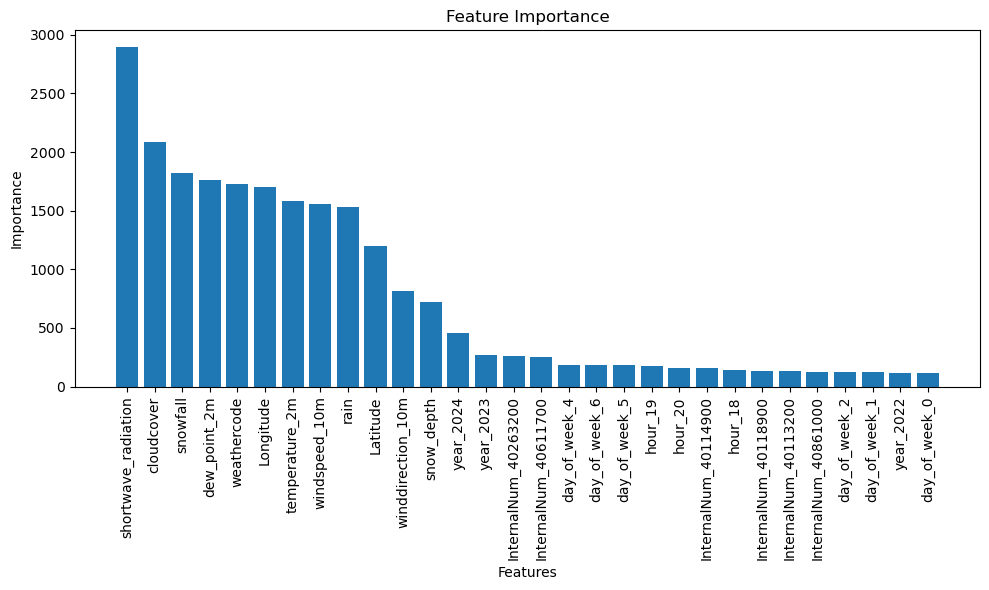

In [9]:
importance = lgbm_model.feature_importances_
feature_names = features
indices = np.argsort(importance)[::-1]
plt.figure(figsize=(10, 6))
plt.bar(range(30), importance[indices[:30]], align='center')
plt.xticks(range(30), [feature_names[i] for i in indices[:30]], rotation=90)
plt.title('Feature Importance')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.tight_layout()
plt.show()

In [ ]:
import shap

explainer = shap.Explainer(lgbm_model, X)

# Calculate SHAP values
shap_values = explainer(X)

# Compute mean absolute SHAP value for each feature
shap_importance = np.abs(shap_values.values).mean(axis=0)

# Get feature names and sort by importance
feature_names = X.columns
indices = np.argsort(shap_importance)[::-1]

# Plot the SHAP feature importances
plt.figure(figsize=(10, 6))
plt.bar(range(len(shap_importance)), shap_importance[indices], align='center')
plt.xticks(range(len(shap_importance)), [feature_names[i] for i in indices], rotation=90)
plt.title('SHAP Feature Importance')
plt.xlabel('Features')
plt.ylabel('Mean Absolute SHAP Value')
plt.tight_layout()
plt.show()

  6%|=                   | 60353/994485 [04:20<67:04]       